In [107]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch
import functions.handy_functions as hf

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [108]:
#Set directory of found pairs
main_dir='/cloud/skogsstyrelsen_pairs/'
directories=os.listdir(main_dir)

In [109]:
#Import and format data
ims_all=[]
temporals_all=[]
for dir in directories:
    data_clear=xr.load_dataset(main_dir+dir+'/clear_data.nc', engine='netcdf4', decode_times=True)
    data_cloudy=xr.load_dataset(main_dir+dir+'/cloudy_data.nc', engine='netcdf4', decode_times=True)

    variables=data_clear.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data

    ## Save image ##
    im_clear=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
    im_clear[:,:,0]=b02
    im_clear[:,:,1]=b03
    im_clear[:,:,2]=b04
    im_clear[:,:,3]=b05
    im_clear[:,:,4]=b06
    im_clear[:,:,5]=b07
    im_clear[:,:,6]=b08
    im_clear[:,:,7]=b8a
    im_clear[:,:,8]=b09
    im_clear[:,:,9]=b10
    im_clear[:,:,10]=b11
    im_clear[:,:,11]=b12
    im_clear[:,:,12]=sun_z

    variables=data_cloudy.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data

    ## Save image ##
    im_cloudy=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
    im_cloudy[:,:,0]=b02
    im_cloudy[:,:,1]=b03
    im_cloudy[:,:,2]=b04
    im_cloudy[:,:,3]=b05
    im_cloudy[:,:,4]=b06
    im_cloudy[:,:,5]=b07
    im_cloudy[:,:,6]=b08
    im_cloudy[:,:,7]=b8a
    im_cloudy[:,:,8]=b09
    im_cloudy[:,:,9]=b10
    im_cloudy[:,:,10]=b11
    im_cloudy[:,:,11]=b12
    im_cloudy[:,:,12]=sun_z

    im_pair=[im_clear,im_cloudy]
    ims_all.append(im_pair)
    temporals_all.append([data_clear.coords['t'].data[0],data_cloudy.coords['t'].data[0]])

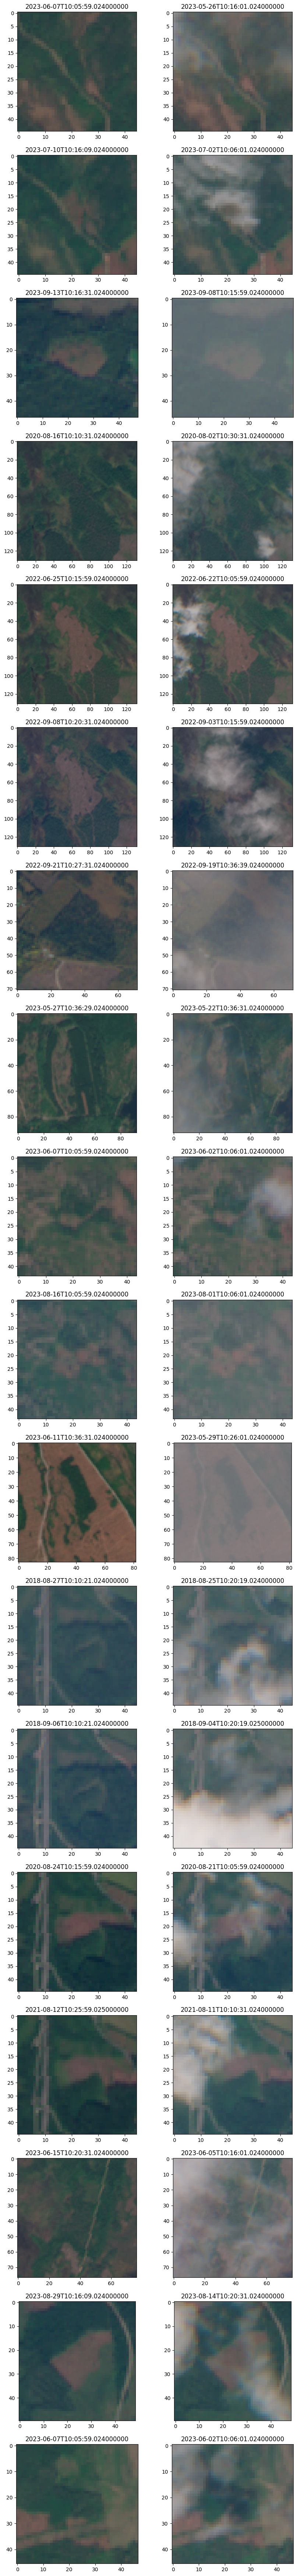

In [110]:
#Plot all clear/cloudy pairs
ncols=2
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    pair_c+=1

In [111]:
#For trials with COT est:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load all COT est models
model_load_paths=['smhi_models4/0/model_it_2000000','smhi_models4/1/model_it_2000000', 'smhi_models4/2/model_it_2000000','smhi_models4/3/model_it_2000000', 'smhi_models4/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

#Set training data means and std's for normalization
#Old dataset
#means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
#stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

#New dataset
means=[0.53892259,0.53099263,0.57942695,0.63021796,0.75956282,0.80769642,0.76741546,0.83960689,0.40266414,0.06668102,0.44278633,0.34460005,58.06583835]
stds =[0.19926734,0.17573319,0.17915619,0.1654085,0.1573165,0.15798441,0.15100182,0.15840717,0.23289204,0.09668435,0.3132122,0.22072329,15.56994119282951]


In [112]:
#Make COT_predictions and append to cloudy image data, both estimation and thresholded dummies
ims_all_wCOT=[]
ims_all_wCOT_dum=[]
for i,pair in enumerate(ims_all):
    im_clear=pair[0]
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    #Normalize
    inputs = (im_cloud_r - means) / stds

    image_input_tens=torch.Tensor(inputs).to(device)

    #Make predictions
    preds = 0
    for model_cot in models_cot:
        curr_preds=model_cot(image_input_tens)/len(models_cot)
        preds=preds+curr_preds

    image_pred_cot=50*preds.cpu().data.numpy() #unnormalise

    #Sort into categories instead
    t_is_cloud = 0.025*50 #From Pirinen et. al.
    t_thin_cloud = 0.015*50 #From Pirinen et. al.

    pred_clear = np.zeros(image_pred_cot.shape)
    pred_thin = np.zeros(image_pred_cot.shape)
    pred_thick = np.zeros(image_pred_cot.shape)

    pred_clear[image_pred_cot<t_thin_cloud]=1
    pred_thin[(image_pred_cot>=t_thin_cloud)&(image_pred_cot<t_is_cloud)]=1
    pred_thick[image_pred_cot>=t_is_cloud]=1

    # Reshape back
    im_pred_cot=np.reshape(image_pred_cot,[im_shape[0],im_shape[1],1])
    im_pred_clear=np.reshape(pred_clear,[im_shape[0],im_shape[1],1])
    im_pred_thin=np.reshape(pred_thin,[im_shape[0],im_shape[1],1])
    im_pred_thick=np.reshape(pred_thick,[im_shape[0],im_shape[1],1])

    #append COT-est to cloudy image set
    im_cloud_wCOT=np.concatenate((im_cloud,im_pred_cot),axis=2)
    im_pair=[im_clear,im_cloud_wCOT]
    ims_all_wCOT.append(im_pair)

    #append COT-est dummies to cloudy image set
    im_cloud_wCOT_dum=np.concatenate((im_cloud,im_pred_clear,im_pred_thin,im_pred_thick),axis=2)
    im_pair=[im_clear,im_cloud_wCOT_dum]
    ims_all_wCOT_dum.append(im_pair)


    

In [113]:
#Load tuned model
main_filepath='pytorch_models/Ultimate_model'
n_ensemble=10
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

quantiles = np.array([0.1,0.5,0.9])
est = np.where(quantiles==0.5)[0].item()
 

In [114]:
#Make predictions and save with uncertanties

preds_all=[]
uncertainties_all=[]
lower_all=[]
higher_all=[]
for i,pair in enumerate(ims_all_wCOT_dum):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r[:,:13])
        else:   
            pred=pred+model.predict(im_cloud_r[:,:13])
    pred=pred/len(models)

    #Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    im_lower=np.zeros(im_shape_pred)
    im_higher=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,est],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])
        im_lower[:,:,i]=np.reshape(pred[:,i,0],im_shape_pred[0:2])
        im_higher[:,:,i]=np.reshape(pred[:,i,-1],im_shape_pred[0:2])


    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)
    lower_all.append(im_lower)
    higher_all.append(im_higher)

In [115]:
im_cloud_r[0,:]

array([1.92300000e-01, 1.71800000e-01, 1.60800000e-01, 2.02200000e-01,
       3.08700000e-01, 3.42900000e-01, 3.40500000e-01, 3.69100000e-01,
       1.78400000e-01, 5.40000000e-03, 2.53900000e-01, 1.89200000e-01,
       3.09425385e+01, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00])

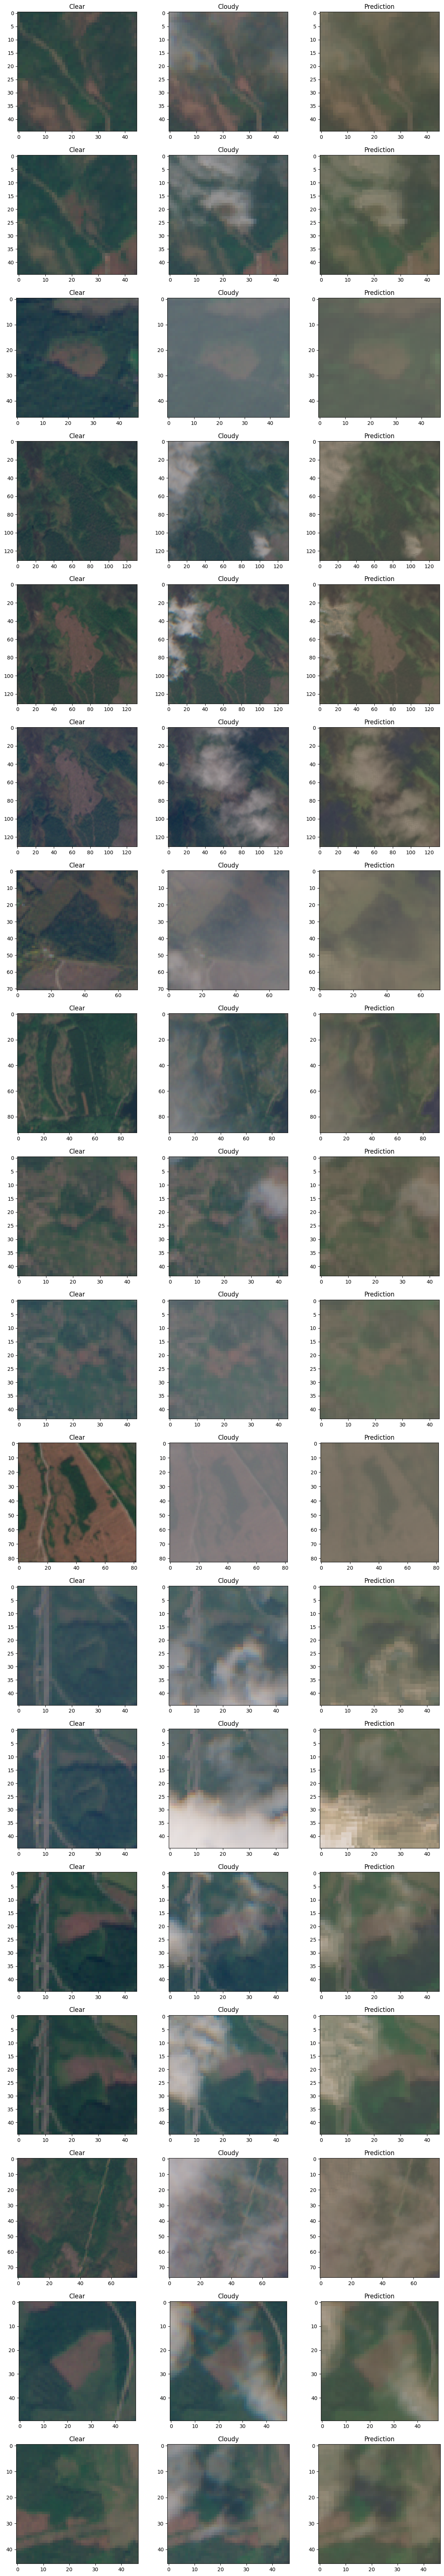

In [116]:
#Print clear, cloudy and predictions
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title('Clear')
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title('Cloudy')
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(preds_all[i]))
    axs[pair_c,2].set_title('Prediction')
    pair_c+=1

In [117]:
#Evaluate through NMSE

n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm((im_clear[:,:,0:12])-(im_cloud[:,:,0:12]),axis=(0,1))**2
    norm_pred=np.linalg.norm((im_clear[:,:,0:12])-im_pred[:,:,0:12],axis=(0,1))**2
    norm_gt=np.linalg.norm(im_clear[:,:,0:12],axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))


NMSE before correction, Band 2: 0.40022542608828293
NMSE after correction, Band 2: 0.08434706923592664
 
NMSE before correction, Band 3: 0.6212890787256616
NMSE after correction, Band 3: 0.26499594094427564
 
NMSE before correction, Band 4: 1.5116504378187048
NMSE after correction, Band 4: 0.8071015198158871
 
NMSE before correction, Band 5: 0.7250211653587733
NMSE after correction, Band 5: 0.43006447233834666
 
NMSE before correction, Band 6: 0.18495176309883093
NMSE after correction, Band 6: 0.15215845494792277
 
NMSE before correction, Band 7: 0.14537585927097002
NMSE after correction, Band 7: 0.10651019373385483
 
NMSE before correction, Band 8: 0.1327387139056492
NMSE after correction, Band 8: 0.09658043841721364
 
NMSE before correction, Band 8A: 0.12652202716872862
NMSE after correction, Band 8A: 0.07250825273339781
 
NMSE before correction, Band 9: 0.6173873387396649
NMSE after correction, Band 9: 0.4312250718302168
 
NMSE before correction, Band 10: 1.8206887445567332
NMSE aft

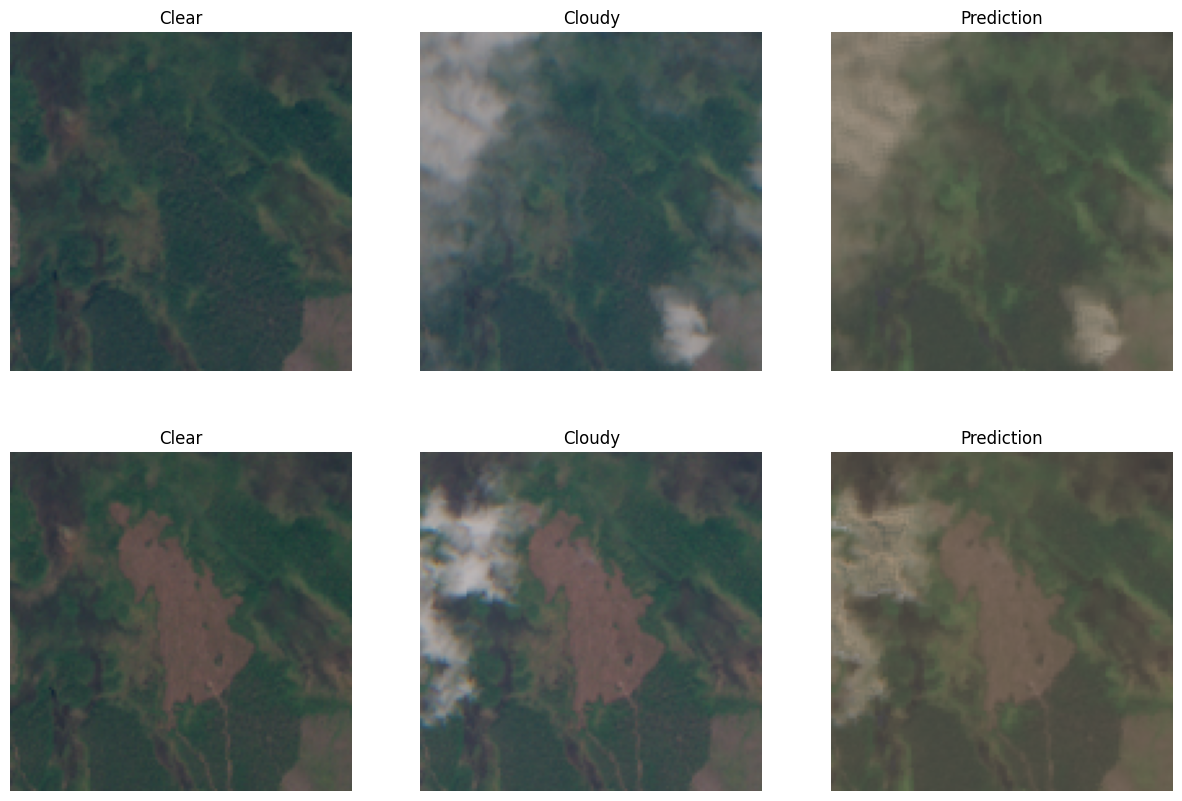

In [118]:
#Chosen image examples:
show_pairs= [3,4]

#Print clear, cloudy and predictions
ncols=3
nrows=len(show_pairs)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i in show_pairs:
    pair = ims_all[i]
    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title('Clear')
    axs[pair_c,0].set_axis_off()
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title('Cloudy')
    axs[pair_c,1].set_axis_off()
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(preds_all[i]))
    axs[pair_c,2].set_title('Prediction')
    axs[pair_c,2].set_axis_off()
    pair_c+=1

#fig.suptitle('Clear truth, cloudy input and prediction example images')

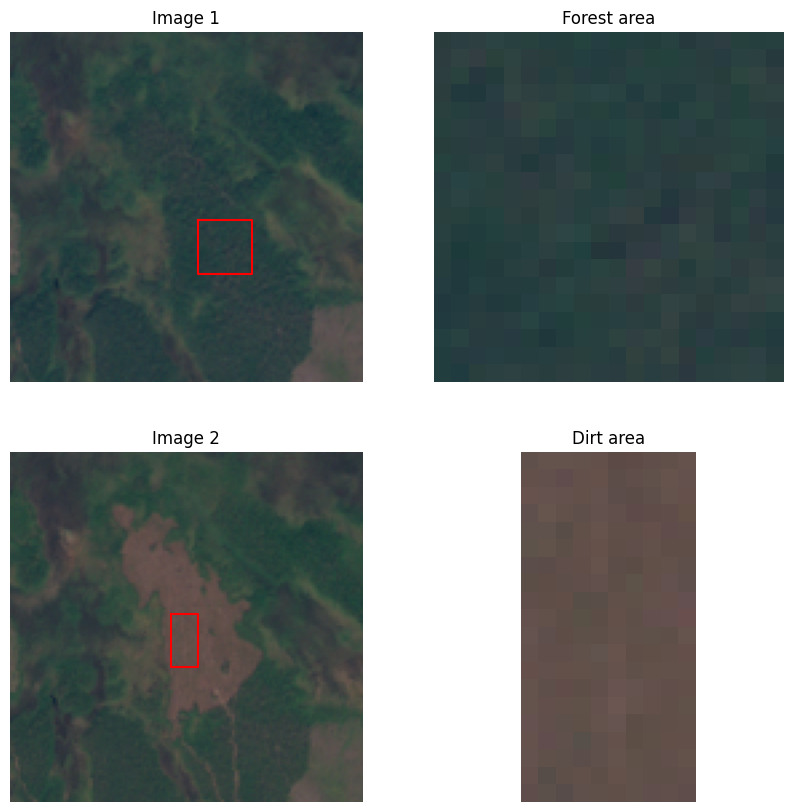

In [119]:
#Find clear images and plot with boxes, dirt and forest.
ybox_im1=[70,90]
xbox_im1=[70,90]
ybox_im2=[60,80]
xbox_im2=[60,70]
xs1 = [xbox_im1[0], xbox_im1[0], xbox_im1[1], xbox_im1[1], xbox_im1[0]]
ys1 = [ybox_im1[0], ybox_im1[1], ybox_im1[1], ybox_im1[0], ybox_im1[0]]
xs2 = [xbox_im2[0], xbox_im2[0], xbox_im2[1], xbox_im2[1], xbox_im2[0]]
ys2 = [ybox_im2[0], ybox_im2[1], ybox_im2[1], ybox_im2[0], ybox_im2[0]]


#Print clear, cloudy and predictions
ncols=2
nrows=2

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

im1 = ims_all[3][0]
im2 = ims_all[4][0]

box1=im1[ybox_im1[0]:ybox_im1[1],xbox_im1[0]:xbox_im1[1],:]
box2=im2[ybox_im2[0]:ybox_im2[1],xbox_im2[0]:xbox_im2[1],:]



axs[0,0].imshow(hf.Sentinel2TrueColor(im1))
axs[0,0].set_title('Image 1')
axs[0,0].set_axis_off()
axs[0,0].plot(xs1, ys1, color="red")
axs[0,1].imshow(hf.Sentinel2TrueColor(box1))
axs[0,1].set_title('Forest area')
axs[0,1].set_axis_off()
axs[1,0].imshow(hf.Sentinel2TrueColor(im2))
axs[1,0].set_title('Image 2')
axs[1,0].set_axis_off()
axs[1,0].plot(xs2, ys2, color="red")
axs[1,1].imshow(hf.Sentinel2TrueColor(box2))
axs[1,1].set_title('Dirt area')
axs[1,1].set_axis_off()

In [120]:
#Print mean reflectivities of box1 and box2
forestmeans = np.mean(box1,axis=(0,1))[:12]
dirtmeans = np.mean(box2,axis=(0,1))[:12]

print('Forest: '+str(forestmeans))
print('Dirt: '+str(dirtmeans))

Forest: [0.0855725  0.06806225 0.044694   0.07437575 0.14659775 0.16814375
 0.16502925 0.184828   0.073099   0.000995   0.11263325 0.05405875]
Dirt: [0.099022  0.0859425 0.089176  0.1118155 0.148396  0.172073  0.170041
 0.200777  0.0432235 0.0009865 0.267628  0.1557145]


Forest preds: [0.08552838 0.07434642 0.05936851 0.08172389 0.15209069 0.16972266
 0.16417941 0.17484921 0.06855732 0.00090245 0.11376167 0.07000237]
Dirt preds: [0.1010866  0.09227336 0.09326391 0.10807134 0.15696589 0.18033894
 0.17379104 0.20224635 0.03263087 0.00041149 0.25242323 0.17184586]
Mean NMSE after correction, forest: 0.021451629908061556
Mean NMSE (except band 10) after correction, forest: 0.020530558520103697
Mean NMSE after correction, dirt: 0.03645515098116101
Mean NMSE (except band 10) after correction, dirt: 0.008302990552819224


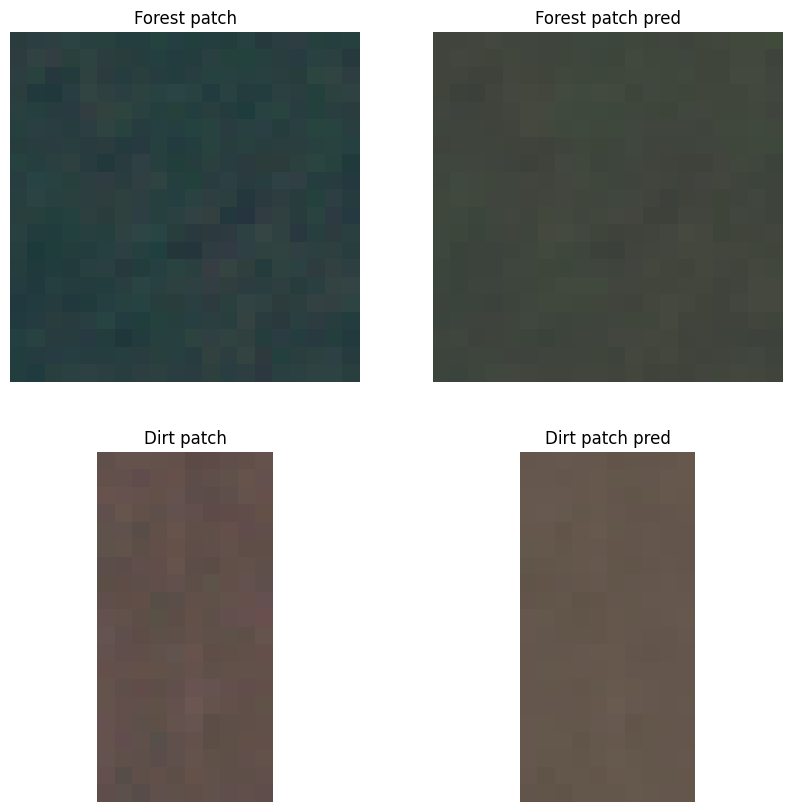

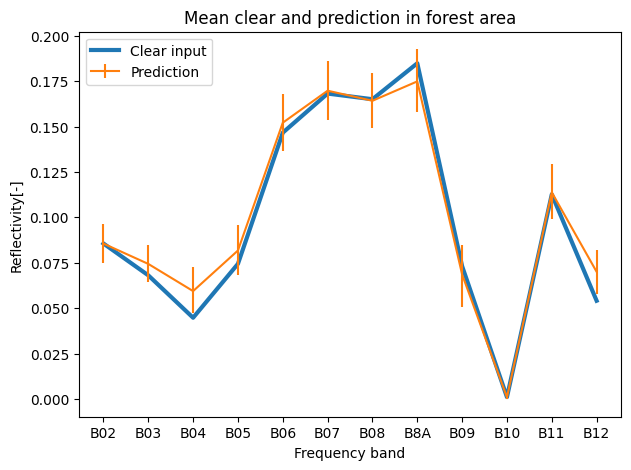

In [121]:
#Make predictions on areas, first forest patch
for_shape=np.shape(box1)
im_for_r=np.zeros((for_shape[0]*for_shape[1],for_shape[2]))
for i in range(for_shape[2]):
    im_for_r[:,i]=np.reshape(box1[:,:,i],for_shape[0]*for_shape[1])
'''
#Make COT pred
#Normalize
inputs = (im_for_r - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)

#Make predictions
preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=50*preds.cpu().data.numpy() #unnormalise

#Sort into categories instead
t_is_cloud = 0.025*50 #From Pirinen et. al.
t_thin_cloud = 0.015*50 #From Pirinen et. al.

pred_clear = np.zeros(image_pred_cot.shape)
pred_thin = np.zeros(image_pred_cot.shape)
pred_thick = np.zeros(image_pred_cot.shape)

pred_clear[image_pred_cot<t_thin_cloud]=1
pred_thin[(image_pred_cot>=t_thin_cloud)&(image_pred_cot<t_is_cloud)]=1
pred_thick[image_pred_cot>=t_is_cloud]=1

#append COT-est dummies to input
im_for_r=np.concatenate((im_for_r,pred_clear,pred_thin,pred_thick),axis=1)
'''
## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_for_r)
    else:   
        pred=pred+model.predict(im_for_r)
pred=pred/len(models)

for_pred_r = pred

#Reshape back
for_shape_pred=(for_shape[0],for_shape[1],12)
for_pred=np.zeros(for_shape_pred)
for_unc=np.zeros(for_shape_pred)
for i in range(for_shape_pred[2]):
    for_pred[:,:,i]=np.reshape(pred[:,i,est],for_shape_pred[0:2])
    for_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],for_shape_pred[0:2])

#Now for dirt patch
dir_shape=np.shape(box2)
im_dir_r=np.zeros((dir_shape[0]*dir_shape[1],dir_shape[2]))
for i in range(dir_shape[2]):
    im_dir_r[:,i]=np.reshape(box2[:,:,i],dir_shape[0]*dir_shape[1])
'''
#Make COT pred
#Normalize
inputs = (im_dir_r - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)

#Make predictions
preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=50*preds.cpu().data.numpy() #unnormalise

#Sort into categories instead
t_is_cloud = 0.025*50 #From Pirinen et. al.
t_thin_cloud = 0.015*50 #From Pirinen et. al.

pred_clear = np.zeros(image_pred_cot.shape)
pred_thin = np.zeros(image_pred_cot.shape)
pred_thick = np.zeros(image_pred_cot.shape)

pred_clear[image_pred_cot<t_thin_cloud]=1
pred_thin[(image_pred_cot>=t_thin_cloud)&(image_pred_cot<t_is_cloud)]=1
pred_thick[image_pred_cot>=t_is_cloud]=1

#append COT-est dummies to input
im_dir_r=np.concatenate((im_dir_r,pred_clear,pred_thin,pred_thick),axis=1)
'''
## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_dir_r)
    else:   
        pred=pred+model.predict(im_dir_r)
pred=pred/len(models)

dir_pred_r=pred
#Reshape back
dir_shape_pred=(dir_shape[0],dir_shape[1],12)
dir_pred=np.zeros(dir_shape_pred)
dir_unc=np.zeros(dir_shape_pred)
for i in range(dir_shape_pred[2]):
    dir_pred[:,:,i]=np.reshape(pred[:,i,est],dir_shape_pred[0:2])
    dir_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],dir_shape_pred[0:2])

#Find mean predictions and uncs
forestmeans_preds = np.mean(for_pred,axis=(0,1))
dirtmeans_preds = np.mean(dir_pred,axis=(0,1))

print('Forest preds: '+str(forestmeans_preds))
print('Dirt preds: '+str(dirtmeans_preds))

#Print clear and predictions
ncols=2
nrows=2

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

axs[0,0].imshow(hf.Sentinel2TrueColor(box1))
axs[0,0].set_title('Forest patch')
axs[0,0].set_axis_off()
axs[0,1].imshow(hf.Sentinel2TrueColor(for_pred))
axs[0,1].set_title('Forest patch pred')
axs[0,1].set_axis_off()
axs[1,0].imshow(hf.Sentinel2TrueColor(box2))
axs[1,0].set_title('Dirt patch')
axs[1,0].set_axis_off()
axs[1,1].imshow(hf.Sentinel2TrueColor(dir_pred))
axs[1,1].set_title('Dirt patch pred')
axs[1,1].set_axis_off()

norm_pred=np.linalg.norm((box1[:,:,:12])-for_pred,axis=(0,1))**2
norm_gt=np.linalg.norm(box1[:,:,:12],axis=(0,1))**2
NMSE_pred=norm_pred/norm_gt
print('Mean NMSE after correction, forest: '+str(np.mean(NMSE_pred)))
bands=np.array([0,1,2,3,4,5,6,7,8,10,11])
print('Mean NMSE (except band 10) after correction, forest: '+str(np.mean(NMSE_pred[bands])))

norm_pred=np.linalg.norm((box2[:,:,:12])-dir_pred,axis=(0,1))**2
norm_gt=np.linalg.norm(box2[:,:,:12],axis=(0,1))**2
NMSE_pred=norm_pred/norm_gt
print('Mean NMSE after correction, dirt: '+str(np.mean(NMSE_pred)))
bands=np.array([0,1,2,3,4,5,6,7,8,10,11])
print('Mean NMSE (except band 10) after correction, dirt: '+str(np.mean(NMSE_pred[bands])))

predmean=np.mean(for_pred_r[:,:,est],axis=0)
lowmean=np.mean(for_pred_r[:,:,0],axis=0)
highmean=np.mean(for_pred_r[:,:,-1],axis=0)
predunc = np.concatenate(((predmean-lowmean).reshape(1,12),(highmean-predmean).reshape(1,12)),axis=0)


plt.rcParams['figure.figsize'] = [7,5]
plt.figure()

plt.plot(range(12),np.mean(im_for_r[:,:12],axis=0),linewidth=3,label='Clear input')
plt.errorbar(range(12),np.mean(for_pred_r[:,:,est],axis=0),yerr=predunc,label='Prediction')
plt.title('Mean clear and prediction in forest area')
plt.legend(loc='upper left')
plt.xticks(np.arange(12), ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.xlabel('Frequency band')
plt.ylabel('Reflectivity[-]')

plt.show()


In [122]:
#Load new dataset model
main_filepath='pytorch_models/Final_model_newsurf_w_clear_noise'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

quantiles = np.array([0.1,0.5,0.9])
est = np.where(quantiles==0.5)[0].item()

#Load new COT est models
model_load_paths=['smhi_models4/0/model_it_2000000','smhi_models4/1/model_it_2000000', 'smhi_models4/2/model_it_2000000','smhi_models4/3/model_it_2000000', 'smhi_models4/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

#Set training data means and std's for normalization
means=[0.53892259,0.53099263,0.57942695,0.63021796,0.75956282,0.80769642,0.76741546,0.83960689,0.40266414,0.06668102,0.44278633,0.34460005,58.06583835]
stds =[0.19926734,0.17573319,0.17915619,0.1654085,0.1573165,0.15798441,0.15100182,0.15840717,0.23289204,0.09668435,0.3132122,0.22072329,15.56994119282951]

Forest preds, new: [0.11135727 0.09119365 0.07893981 0.0954012  0.14354457 0.1582161
 0.15311121 0.16261103 0.05604368 0.00303396 0.11319081 0.08337622]
Dirt preds, new: [0.1209812  0.10634011 0.10360773 0.11748342 0.15698459 0.17781312
 0.17179467 0.19533543 0.03737868 0.00116572 0.21710739 0.16093441]
Mean NMSE after correction, forest: 0.45834804875606966
Mean NMSE (except band 10) after correction, forest: 0.11501458948348668
Mean NMSE after correction, dirt: 0.02004511637223304
Mean NMSE (except band 10) after correction, dirt: 0.017921612000389754


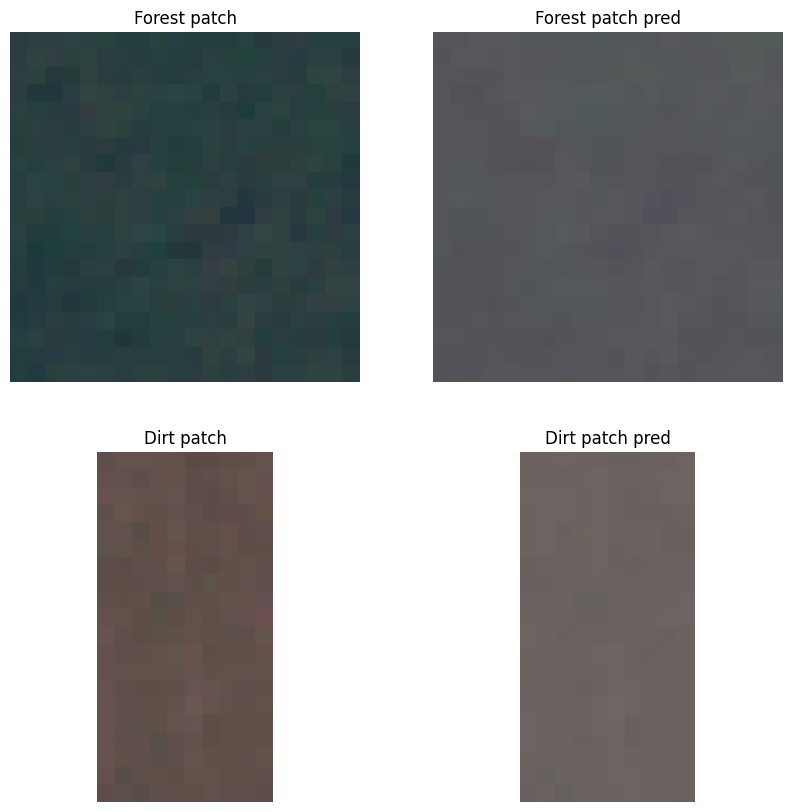

In [123]:
#Make predictions on areas, first forest patch
for_shape=np.shape(box1)
im_for_r=np.zeros((for_shape[0]*for_shape[1],for_shape[2]))
for i in range(for_shape[2]):
    im_for_r[:,i]=np.reshape(box1[:,:,i],for_shape[0]*for_shape[1])

#Make COT pred
#Normalize
inputs = (im_for_r - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)

#Make predictions
preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=50*preds.cpu().data.numpy() #unnormalise

#Sort into categories instead
t_is_cloud = 0.025*50 #From Pirinen et. al.
t_thin_cloud = 0.015*50 #From Pirinen et. al.

pred_clear = np.zeros(image_pred_cot.shape)
pred_thin = np.zeros(image_pred_cot.shape)
pred_thick = np.zeros(image_pred_cot.shape)

pred_clear[image_pred_cot<t_thin_cloud]=1
pred_thin[(image_pred_cot>=t_thin_cloud)&(image_pred_cot<t_is_cloud)]=1
pred_thick[image_pred_cot>=t_is_cloud]=1

#append COT-est dummies to input
im_for_r=np.concatenate((im_for_r,pred_clear,pred_thin,pred_thick),axis=1)

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_for_r)
    else:   
        pred=pred+model.predict(im_for_r)
pred=pred/len(models)

#Reshape back
for_shape_pred=(for_shape[0],for_shape[1],12)
for_pred=np.zeros(for_shape_pred)
for_unc=np.zeros(for_shape_pred)
for i in range(for_shape_pred[2]):
    for_pred[:,:,i]=np.reshape(pred[:,i,est],for_shape_pred[0:2])
    for_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],for_shape_pred[0:2])

#Now for dirt patch
dir_shape=np.shape(box2)
im_dir_r=np.zeros((dir_shape[0]*dir_shape[1],dir_shape[2]))
for i in range(dir_shape[2]):
    im_dir_r[:,i]=np.reshape(box2[:,:,i],dir_shape[0]*dir_shape[1])

#Make COT pred
#Normalize
inputs = (im_dir_r - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)

#Make predictions
preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=50*preds.cpu().data.numpy() #unnormalise

#Sort into categories instead
t_is_cloud = 0.025*50 #From Pirinen et. al.
t_thin_cloud = 0.015*50 #From Pirinen et. al.

pred_clear = np.zeros(image_pred_cot.shape)
pred_thin = np.zeros(image_pred_cot.shape)
pred_thick = np.zeros(image_pred_cot.shape)

pred_clear[image_pred_cot<t_thin_cloud]=1
pred_thin[(image_pred_cot>=t_thin_cloud)&(image_pred_cot<t_is_cloud)]=1
pred_thick[image_pred_cot>=t_is_cloud]=1

#append COT-est dummies to input
im_dir_r=np.concatenate((im_dir_r,pred_clear,pred_thin,pred_thick),axis=1)

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_dir_r)
    else:   
        pred=pred+model.predict(im_dir_r)
pred=pred/len(models)

#Reshape back
dir_shape_pred=(dir_shape[0],dir_shape[1],12)
dir_pred=np.zeros(dir_shape_pred)
dir_unc=np.zeros(dir_shape_pred)
for i in range(dir_shape_pred[2]):
    dir_pred[:,:,i]=np.reshape(pred[:,i,est],dir_shape_pred[0:2])
    dir_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],dir_shape_pred[0:2])

#Find mean predictions and uncs
forestmeans_preds = np.mean(for_pred,axis=(0,1))
dirtmeans_preds = np.mean(dir_pred,axis=(0,1))

print('Forest preds, new: '+str(forestmeans_preds))
print('Dirt preds, new: '+str(dirtmeans_preds))


#Print clear and predictions
ncols=2
nrows=2

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

axs[0,0].imshow(hf.Sentinel2TrueColor(box1))
axs[0,0].set_title('Forest patch')
axs[0,0].set_axis_off()
axs[0,1].imshow(hf.Sentinel2TrueColor(for_pred))
axs[0,1].set_title('Forest patch pred')
axs[0,1].set_axis_off()
axs[1,0].imshow(hf.Sentinel2TrueColor(box2))
axs[1,0].set_title('Dirt patch')
axs[1,0].set_axis_off()
axs[1,1].imshow(hf.Sentinel2TrueColor(dir_pred))
axs[1,1].set_title('Dirt patch pred')
axs[1,1].set_axis_off()

norm_pred=np.linalg.norm((box1[:,:,:12])-for_pred,axis=(0,1))**2
norm_gt=np.linalg.norm(box1[:,:,:12],axis=(0,1))**2
NMSE_pred=norm_pred/norm_gt
print('Mean NMSE after correction, forest: '+str(np.mean(NMSE_pred)))
bands=np.array([0,1,2,3,4,5,6,7,8,10,11])
print('Mean NMSE (except band 10) after correction, forest: '+str(np.mean(NMSE_pred[bands])))

norm_pred=np.linalg.norm((box2[:,:,:12])-dir_pred,axis=(0,1))**2
norm_gt=np.linalg.norm(box2[:,:,:12],axis=(0,1))**2
NMSE_pred=norm_pred/norm_gt
print('Mean NMSE after correction, dirt: '+str(np.mean(NMSE_pred)))
bands=np.array([0,1,2,3,4,5,6,7,8,10,11])
print('Mean NMSE (except band 10) after correction, dirt: '+str(np.mean(NMSE_pred[bands])))